# Exploring ABC Radio National metadata

This notebook shows a few ways you can start to explore the ABC Radio National metadata harvested [using this notebook](harvest-abcrn.ipynb).

For an earlier experiment playing with this data, see [In a word...: Currents in Australian affairs, 2003–2013](https://inaword.herokuapp.com/).

In [1]:
import re
from pathlib import Path

import altair as alt
import nltk
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load the harvested data.

In [2]:
# Download the most recently harvested data file and convert to a dataframe
df = pd.read_csv("https://github.com/GLAM-Workbench/trove-abcrn-data/raw/main/abcrn-metadata.csv")

How many records are there?

In [3]:
df.shape[0]

427141

## Programs

How many programs are there records for?

In [4]:
df["isPartOf"].nunique()

163

Which programs have the most records?

In [5]:
df["isPartOf"].value_counts()[:25]

ABC Radio National. RN Breakfast            63676
ABC Radio. AM                               56009
ABC Radio. The World Today                  51643
ABC Radio. PM                               51231
ABC Radio. RN Breakfast                     19877
ABC Radio National. RN Drive                13785
ABC Radio. RN Drive                         12758
ABC Radio National. Late Night Live         10689
ABC Radio National. Life Matters            10658
ABC Radio. AM Archive                        9825
ABC Radio. PM Archive                        8430
ABC Radio National. The Science Show         8020
ABC Radio. The World Today Archive           7902
ABC Radio National. Saturday Extra           6545
ABC Radio National. Health Report            5041
ABC Radio                                    4638
ABC Radio National. Counterpoint             4472
ABC Radio National. Sunday Extra             4246
ABC Radio. Correspondents Report             4005
ABC Radio National. AWAYE!                   3456


## Number of records by year

To look at the number of records by year, we need to make sure the `date` field is being recognised as a `datetime`. Then we can extract the year into a new column.

In [6]:
#df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
df["year"] = df["date"].str.extract(r"^(\d{4})")

Find the number of times each year appears.

In [7]:
year_counts = df["year"].value_counts().to_frame().reset_index()
year_counts.columns = ["year", "count"]

Chart the results.

In [8]:
alt.Chart(year_counts).mark_bar(size=15).encode(
    x="year:T", y="count:Q", tooltip=[alt.Tooltip("year:T", format="%Y"), alt.Tooltip("count:Q", format=",")]
).properties(width=600)

alt.Chart(...)

The early records look a bit suspect, and I should probably check them manually. I'm also wondering why there's been such a large decline in the number of records added since 2017. 

## People

The `contributor` field includes the names of hosts, reporters, and guests. It's stored as a pipe-delimited string, so we have to split the string, then explode the resulting list to create one row per name.

In [9]:
people = df["contributor"].str.split("|").explode().dropna()

Then we can calculate how often people appear in the records.

In [10]:
people.value_counts()[:25]

Fran Kelly            56806
Mark Colvin           31973
Eleanor Hall          27122
Robyn Williams        15146
Phillip Adams         13426
Patricia Karvelas     13159
Natasha Mitchell      10833
Tony Eastley          10117
Geraldine Doogue       7727
Elizabeth Jackson      7697
Richard Aedy           7188
Linda Mottram          6839
Peter Cave             5430
David Fisher           5313
Dr Norman Swan         5115
Alexandra Kirk         4798
Brendan Trembath       4499
Michael Cathcart       4486
Kim Landers            4484
Michael Brissenden     4257
Sabra Lane             4245
Brigitte Seega         4066
Peter Ryan             4010
Paul Barclay           3930
Jonathan Green         3877
Name: contributor, dtype: int64

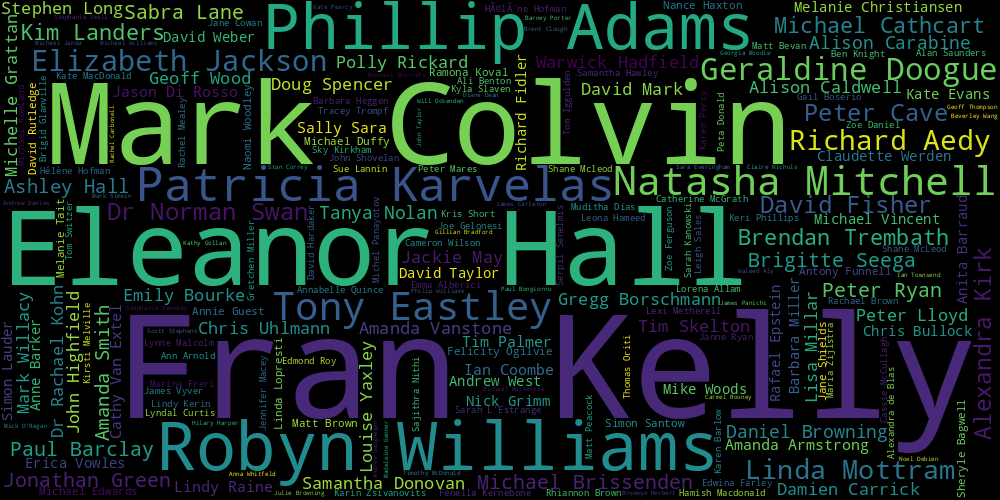

In [11]:
wc_people = WordCloud(width=1000, height=500).fit_words(people.value_counts().to_dict())
wc_people.to_image()

## Titles

There are three text fields that could yield some interesting analysis. The `title` field is obvious enough, though some regular segments do have duplicate titles. The `abstract` field is a brief summary of the segment or program.

Let's try aggregating the titles for a program.

### RN Breakfast in 2020

In [12]:
breakfast_titles = list(
    df.loc[
        (
            df["isPartOf"].isin(
                ["ABC Radio National. RN Breakfast", "ABC Radio. RN Breakfast"]
            )
        )
        & (df["year"] == "2020")
    ]
    .drop_duplicates(subset=["title"], keep=False)["title"]
    .unique()
)

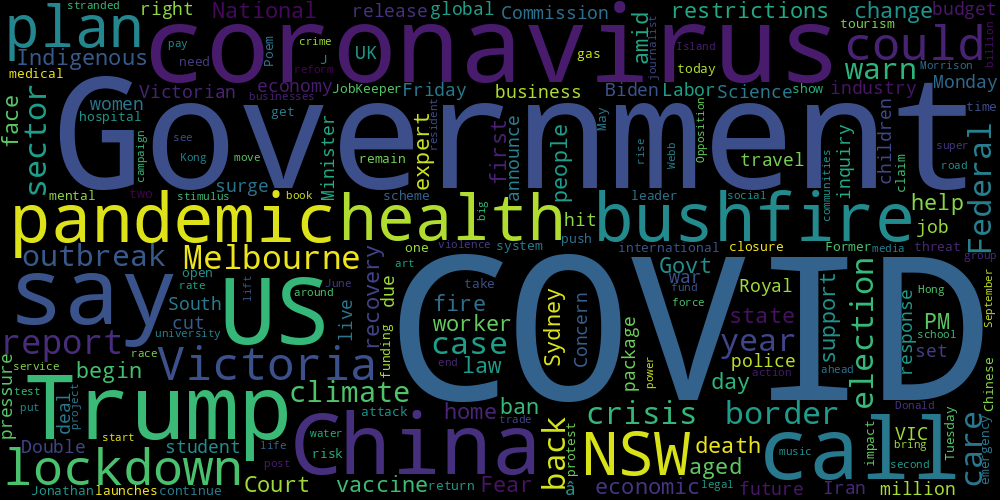

In [13]:
wordcloud = WordCloud(
    width=1000,
    height=500,
    stopwords=stopwords.words("english")
    + [
        "Australia",
        "Australian",
        "Australians",
        "New",
        "News",
        "Matt",
        "Bevan",
        "World",
    ],
    collocations=False,
).generate(" ".join(breakfast_titles))
wordcloud.to_image()

## RN Drive in 2020

In [14]:
drive_titles = list(
    df.loc[
        (df["isPartOf"].isin(["ABC Radio National. RN Drive", "ABC Radio. RN Drive"]))
        & (df["year"] == "2020")
    ]
    .drop_duplicates(subset=["title"], keep=False)["title"]
    .unique()
)

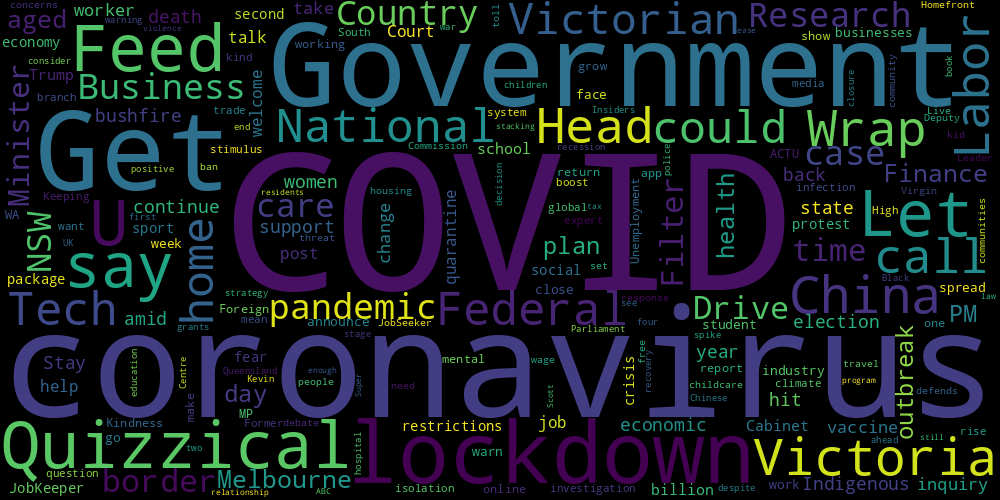

In [15]:
wordcloud = WordCloud(
    width=1000,
    height=500,
    stopwords=stopwords.words("english")
    + [
        "Australia",
        "Australian",
        "Australians",
        "New",
        "News",
        "Matt",
        "Bevan",
        "World",
    ],
    collocations=False,
).generate(" ".join(drive_titles))
wordcloud.to_image()

## Title words over time

We can also look to see how often particular words or phrases appeared in the titles of RN segments or programs. This could of course be filtered by program, as above.

### Bushfires

In [16]:
# Drop records without a title
df_titles = df.dropna(subset=["title"])
# Find titles containing 'bushfire'
bushfires = df_titles.loc[
    df["title"].dropna().str.contains(r"bushfire", regex=True, flags=re.IGNORECASE)
]

In [17]:
# Chart the results
alt.Chart(bushfires).mark_line().encode(
    x="year(date):T", y="count()", tooltip=["year(date):T", "count():Q"]
)

alt.Chart(...)

### Refugees

In [18]:
refugees = df_titles.loc[
    df["title"].dropna().str.contains(r"refugee", regex=True, flags=re.IGNORECASE)
]
alt.Chart(refugees).mark_line().encode(
    x="year(date):T", y="count():Q", tooltip=["year(date):T", "count():Q"]
)

alt.Chart(...)

### Climate change / global warming

In [19]:
climate = df_titles.loc[
    df["title"]
    .dropna()
    .str.contains(r"(?:climate change|global warming)", regex=True, flags=re.IGNORECASE)
]
alt.Chart(climate).mark_line().encode(
    x="year(date):T", y="count():Q", tooltip=["year(date):T", "count():Q"]
)

alt.Chart(...)

### Trump

In [20]:
trump = df_titles.loc[
    df["title"].dropna().str.contains(r"\btrump\b", regex=True, flags=re.IGNORECASE)
]
alt.Chart(trump).mark_line().encode(
    x="year(date):T", y="count():Q", tooltip=["year(date):T", "count():Q"]
)

alt.Chart(...)

----

Created by [Tim Sherratt](https://timsherratt.org) for the [GLAM Workbench](https://glam-workbench.github.io/)